In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import io,restoration
from tifffile import imsave
from tqdm import tqdm
from time import time
from skimage import exposure,segmentation,morphology,measure,filters
from skimage.measure import block_reduce
from skimage.feature import peak_local_max
from skimage import filters
from math import ceil
from scipy.ndimage import zoom
from scipy import ndimage as ndi
import cv2
import glob
import os
from PIL import ImageFilter
import morphsnakes as ms
from skimage.transform import resize

# import skvideo.io


def image_show(image, nrows=1, ncols=1, cmap='gray',size = 8):
#     large_image = np.zeros((image.shape[0]+2,image.shape[1]+2), dtype = image.dtype) #add black border
#     large_image[1:-1,1:-1] = image
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    
    plt.show();
    return fig, ax

# Batch process

###########----------biopsy group: s140_o
----------biopsy_name: dod_s140a


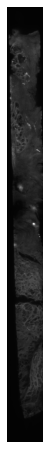

cyto.shape (727, 12544, 1024)
cyto.amax(cyto_ds) 255
cyto_ds.shape (46, 784, 64)
(46, 784, 64)
(52, 790, 70)
time for active contour: 45.895651
1 0 int8


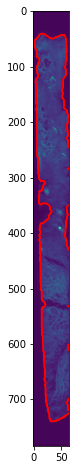

ds2.shape (364, 6272, 512)


C:\Users\ADMINI~1\AppData\Local\Temp\2/ipykernel_14704/194642362.py:90: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_up = resize(seg.astype(np.bool), ds2.shape, order = 0) #nearest neighbor #old size:(356,seg.shape[1]*8, seg.shape[2]*8)


93.4119565486908 s, time for upsampling
(364, 6272, 512)


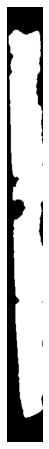

In [2]:
v2v_result_dir = 'Z:\\WX\\WX_test_dod\\whobio_sets\\vid2vid_results' #change
# biopsy_group_list = ['s018cf', 's020a', 's020bf','s021bc','s021df','s028ac','s028df','s029ac','s029df','s039ab','s039cf'] #change
# biopsy_group_list = ['s034ac_o', 's032_o', 's002_o', 's003_o', 's004_o', 's011_o', 's012_o', 's009_o'] #change
# biopsy_group_list = ['s065_o','s066_o','s068_o','s005_o','s038_o'] #,
# biopsy_group_list = ['s123f_o','s126_o','s143_o','s093_o','s100_o','s125_o','s093f_o','s092_o','s144_o','s142_o','s146_o','s148_o']
biopsy_group_list = ['s140_o']
# first need ck8 ds2 file to perform


for biopsy_group in biopsy_group_list:
    
    print('###########----------biopsy group:', biopsy_group)
    biopsy_group_dir = v2v_result_dir+'\\'+biopsy_group+'\\full_seq' #full_seq_dir
    biopsy_list = glob.glob(os.path.join(biopsy_group_dir,'dod_*'))
#     print(biopsy_list)
    for biopsy_dir in biopsy_list: #biopsy_list #pay attention!!!!!!!

        biopsy_name = os.path.basename(biopsy_dir) #dod+sxxx
        print('----------biopsy_name:', biopsy_name)
        block_name = biopsy_name[4:] #sxxx
        biopsy_seg_dir = os.path.join(biopsy_group_dir, 'Fused_'+biopsy_name)
        stack_path = os.path.join(biopsy_seg_dir, biopsy_name)
        cyto_dir = os.path.join(biopsy_seg_dir,'ch2')+'\\'+block_name+'_ch2.tif'

        #read cytoplasm channel
        cyto = io.imread(cyto_dir)

        #downsample cytoplasm channel
        ds_time = 16
        cyto_ds = block_reduce(cyto, block_size=(ds_time, ds_time, ds_time), func=np.mean).astype(np.uint8)   
        image_show(cyto_ds[cyto_ds.shape[0]//2]);
        cyto_save_path = os.path.join(os.path.dirname(stack_path)+'\\get_biopsy_outline', block_name+'_cyto')
        if not os.path.exists(os.path.dirname(cyto_save_path)):
            os.makedirs(os.path.dirname(cyto_save_path))
        imsave(cyto_save_path+'_ds'+str(ds_time)+'.tif', cyto_ds)
        print('cyto.shape', cyto.shape)
        print('cyto.amax(cyto_ds)', np.amax(cyto_ds))
        print('cyto_ds.shape', cyto_ds.shape)

        del cyto #release memory


        #3d active contour- chan_vese
        img = np.clip(cyto_ds,0,255) #automatic way to come up with this threshold?

        #pad img
        pad_size = 3
        print(img.shape)
        img = np.pad(img, pad_size, 'edge')
        print(img.shape)

        init_ls = np.zeros(img.shape,dtype = np.int8)
        init_ls[pad_size:-pad_size:,pad_size:-pad_size,pad_size:-pad_size] = 1
#         image_show(init_ls[init_ls.shape[0]//2])

        # Morphological Chan-Vese (or ACWE)
        t0 = time()
        seg = ms.morphological_chan_vese(img, 30, init_level_set=init_ls,
                                   smoothing=2, lambda1=1, lambda2=4)
        t1 = time()
        print('time for active contour: %f' %(t1 - t0))
        print(np.amax(seg), np.amin(seg), seg.dtype)

        # seg = ndi.morphology.binary_erosion(seg,iterations=pad_size) #make area smaller
        seg = seg[pad_size:-pad_size:,pad_size:-pad_size:,pad_size:-pad_size].astype(np.uint8)*255
        img = img[pad_size:-pad_size:,pad_size:-pad_size:,pad_size:-pad_size]
        # seg = seg.astype(np.uint8)*255

#         fig = plt.figure(figsize=(8,8))
#         plt.imshow(img[img.shape[0]//4])
#         plt.contour(seg[seg.shape[0]//4], colors='red', linewidths=1)
#         plt.show()

        fig = plt.figure(figsize=(8,8))
        plt.imshow(img[img.shape[0]//2])
        plt.contour(seg[seg.shape[0]//2], colors='red', linewidths=1)
        plt.show()

#         fig = plt.figure(figsize=(8,8))
#         plt.imshow(img[img.shape[0]//4*3])
#         plt.contour(seg[seg.shape[0]//4*3], colors='red', linewidths=1)
#         plt.show()

        #get target size
        ds2_dir = os.path.join(biopsy_seg_dir,biopsy_name+'_ds2.tif')
        ds2 = io.imread(ds2_dir)
        print('ds2.shape', ds2.shape)

        time_s = time()
        seg_up = resize(seg.astype(np.bool), ds2.shape, order = 0) #nearest neighbor #old size:(356,seg.shape[1]*8, seg.shape[2]*8)

        del ds2 #release memory

        seg_up = (seg_up*255).astype(np.uint8)
        time_e = time()
        print(time_e-time_s,'s, time for upsampling')
        print(seg_up.shape)
        image_show(seg_up[seg_up.shape[0]//2])
        imsave(cyto_save_path+'biopsyContour_ds2.tif', seg_up)



#         imsave(cyto_save_path+'biopsyContour_ds'+str(ds_time)+'.tif', seg)

# Individual

In [ ]:
block_name = 's058e'
stack_path = 'W:\\WX_test_dod\\whole_biopsy\\vid2vid_results\\test_whbio4biopsies\\full_seq\\Fused_dod_'+block_name+'\\dod_'+block_name

#import cyto channel and downsample to same size (dod enface)
cyto_dir = 'W:\\WX_test_dod\\whole_biopsy\\vid2vid_results\\test_whbio4biopsies\\full_seq\\Fused_dod_'+block_name+'\\ch2\\'+block_name+'_ch2.tif'
cyto = io.imread(cyto_dir)

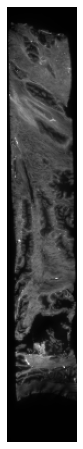

cyto.shape (712, 6400, 1024)
cyto.amax(cyto_ds) 255
cyto_ds.shape (45, 400, 64)


In [12]:
ds_time = 16
cyto_ds = block_reduce(cyto, block_size=(ds_time, ds_time, ds_time), func=np.mean).astype(np.uint8)
image_show(cyto_ds[cyto_ds.shape[0]//2]);
cyto_save_path = os.path.join(os.path.dirname(stack_path)+'\\get_biopsy_outline', block_name+'_cyto')
if not os.path.exists(os.path.dirname(cyto_save_path)):
    os.makedirs(os.path.dirname(cyto_save_path))
imsave(cyto_save_path+'_ds'+str(ds_time)+'.tif', cyto_ds)
print('cyto.shape', cyto.shape)
print('cyto.amax(cyto_ds)', np.amax(cyto_ds))
print('cyto_ds.shape', cyto_ds.shape)

(45, 400, 64)
(51, 406, 70)


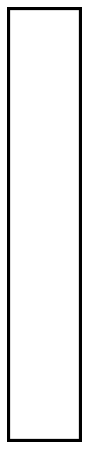

time for active contour: 13.795884
1 0 int8


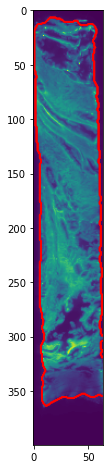

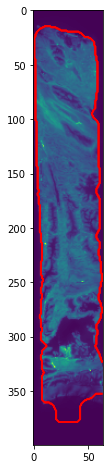

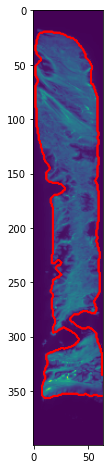

In [13]:
#3d - chan_vese

# Load the image.
# PATH_IMG_CAMERA = '/Users/annax/Desktop/camera.png'
# stack_path = '/Users/annax/Desktop/usep2pfirst/dod_result_long/05092020/real_A_rearrange(blue).tif'
# img_raw = io.imread(stack_path)
# img = block_reduce(img_raw, block_size=(8, 8, 8), func=np.mean)
img = np.clip(cyto_ds,0,255) #automatic way to come up with this threshold?
# gimg = ms.inverse_gaussian_gradient(img, alpha=500, sigma=1)
# image_show(gimg[gimg.shape[0]//2])
# imsave(cyto_save_path+'invGaussGrad_ds'+str(ds_time)+'.tif', (gimg*255).astype(np.uint8))

# #pad gimg
# pad_size = 3
# print(img.shape)
# gimg = np.pad(gimg, pad_size, 'edge')
# print(gimg.shape)

#pad img
pad_size = 3
print(img.shape)
img = np.pad(img, pad_size, 'edge')
print(img.shape)

# init_ls = ms.checkerboard_level_set(img.shape)
# init_ls = ms.circle_level_set((50,50), (25, 25), 10)
# image_show(init_ls)
init_ls = np.zeros(img.shape,dtype = np.int8)
init_ls[pad_size:-pad_size:,pad_size:-pad_size,pad_size:-pad_size] = 1
image_show(init_ls[init_ls.shape[0]//2])

# Morphological Chan-Vese (or ACWE)
t0 = time()
seg = ms.morphological_chan_vese(img, 20, init_level_set=init_ls,
                           smoothing=2, lambda1=1, lambda2=4)
t1 = time()
print('time for active contour: %f' %(t1 - t0))
print(np.amax(seg), np.amin(seg), seg.dtype)

# seg = ndi.morphology.binary_erosion(seg,iterations=pad_size) #make area smaller
seg = seg[pad_size:-pad_size:,pad_size:-pad_size:,pad_size:-pad_size].astype(np.uint8)*255
img = img[pad_size:-pad_size:,pad_size:-pad_size:,pad_size:-pad_size]
# seg = seg.astype(np.uint8)*255

fig = plt.figure(figsize=(8,8))
plt.imshow(img[img.shape[0]//4])
plt.contour(seg[seg.shape[0]//4], colors='red', linewidths=1)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.imshow(img[img.shape[0]//2])
plt.contour(seg[seg.shape[0]//2], colors='red', linewidths=1)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.imshow(img[img.shape[0]//4*3])
plt.contour(seg[seg.shape[0]//4*3], colors='red', linewidths=1)
plt.show()

imsave(cyto_save_path+'biopsyContour_ds'+str(ds_time)+'.tif', seg)

# Rescale up to 2X downsample (8X upsampling)
# - option 1: use imageJ(scale, indicate pixels, no interpolation), 
# - option 2: use skimage.transform.resize to upsample in nearest-neighbor interpolation mode (already implemented)

(45, 688, 64)
305.1034286022186 s
(356, 5504, 512)


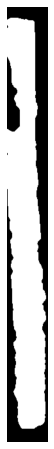

In [12]:
# # for test
# from skimage.transform import resize

# print(seg.shape)
# time_s = time()
# seg_up = resize(seg.astype(np.bool),(356,seg.shape[1]*8, seg.shape[2]*8), order = 0) #nearest neighbor
# seg_up = (seg_up*255).astype(np.uint8)
# time_e = time()
# print(time_e-time_s,'s')
# print(seg_up.shape)
# image_show(seg_up[seg_up.shape[0]//2])
# imsave(cyto_save_path+'biopsyContour_ds2_python.tif', seg_up)